In [6]:
import os
import pandas as pd
from datetime import datetime
from typing import Union, List, Optional
import glob


def check_timestamp_coverage(
    folder: str,
    filenames: Optional[List[str]] = None,
    start_ts: int = None, # unix timestamp
    window: int = None,
    threshold: Union[int, float] = None, # either the absolute number of percentage
    interval: int = 720  # interval in minutes
) -> List[str]:
    """
    Check timestamp coverage in parquet files and return files meeting the threshold.
    threshold: 1 means use datasets with no missing values, 0 means use all datasets
    
    Args:
        folder: Base folder path containing parquet files
        filenames: Optional list of specific filenames to process. If None, process all .parquet files in folder
        start_time: Start time as string in format "YYYY-MM-DD" or "YYYY-MM-DD HH:MM:SS"
        window: Number of timestamps to check (including start time if valid)
        threshold: Minimum number of timestamps required (integer) or percentage (float <= 1)
        interval: Time interval in minutes between consecutive timestamps (default: 720)
    
    Returns:
        List of filenames that have >= threshold timestamps in the specified range
    """

    # # Convert start_time to datetime
    # if len(start_time.split()) == 1:  # Only date provided
    #     start_time = pd.to_datetime(start_time + " 00:00:00")
    # else:
    #     start_time = pd.to_datetime(start_time)
    
    # start_ts = int(start_time.timestamp())
    end_ts = start_ts + window * interval * 60
    
    # Get list of files to process
    if filenames is not None:
        files = [os.path.join(folder, f) for f in filenames]
    else:
        files = glob.glob(os.path.join(folder, "*.parquet"))

    if threshold==0:
        threshold=1
    elif (isinstance(threshold, float) and threshold <= 1) or threshold==1:
        threshold = int(window * threshold)

    valid_files = []    
    for file in files:
        try:
            # Read parquet file
            df = pd.read_parquet(file, columns=['timestamp'])
            ts_col = df['timestamp'] 
            # Count timestamps in range
            ts_in_range = ((ts_col >= start_ts) & (ts_col < end_ts)).sum()
            if ts_in_range >= threshold:
                valid_files.append(os.path.basename(file))
                
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
            continue
    
    return valid_files 

In [11]:
def date2unix(date: str) -> int:
    return int(datetime.strptime(date, "%Y-%m-%d").timestamp())

date2unix('2022-01-01')

1641024000

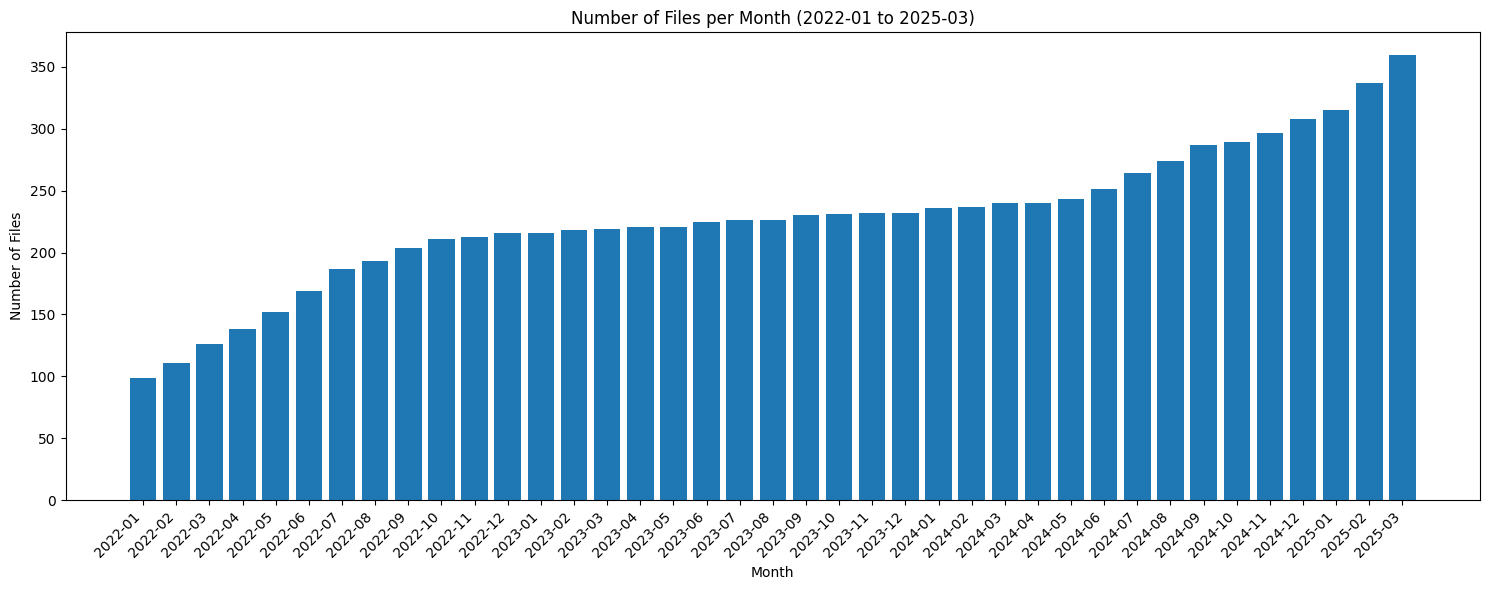

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_monthly_coverage(start_month: str, end_month: str, threshold: int | float):
    """
    Analyze monthly coverage of files, generate a plot, and save results.
    
    Args:
        start_month (str): Start month in 'YYYY-MM' format (e.g., '2022-01')
        end_month (str): End month in 'YYYY-MM' format (e.g., '2025-03')
        threshold (float): Threshold for file coverage (default: 0.8)
    """
    # Convert month strings to full dates
    start_date = f"{start_month}-01"
    end_date = f"{end_month}-01"
    
    # Generate list of first day of each month
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    all_files = []
    for date in date_range:
        start_ts = int(date.timestamp())
        files = check_timestamp_coverage(
            folder='USD_720',
            start_ts=start_ts,
            window=60,
            threshold=threshold,
            interval=720
        )
        all_files.append(files)
    
    # Create the plot
    file_counts = pd.Series([len(lst) for lst in all_files], index=date_range)
    
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(file_counts)), file_counts.values)
    
    # Customize x-axis labels
    plt.xticks(range(len(file_counts)), 
               [d.strftime('%Y-%m') for d in file_counts.index],
               rotation=45, ha='right')
    
    plt.title(f'Number of Files per Month ({start_month} to {end_month})')
    plt.xlabel('Month')
    plt.ylabel('Number of Files')
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f'datasets_{start_month.replace("-", "-")}_{end_month.replace("-", "-")}_720_{threshold}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save the files list to a JSON file
    json_filename = f'datasets_{start_month.replace("-", "-")}_{end_month.replace("-", "-")}_720_{threshold}.json'
    with open(json_filename, 'w') as f:
        json.dump(all_files, f, indent=2)
    
    return all_files

# Example usage:
# files = analyze_monthly_coverage('2022-01', '2025-03', 1)

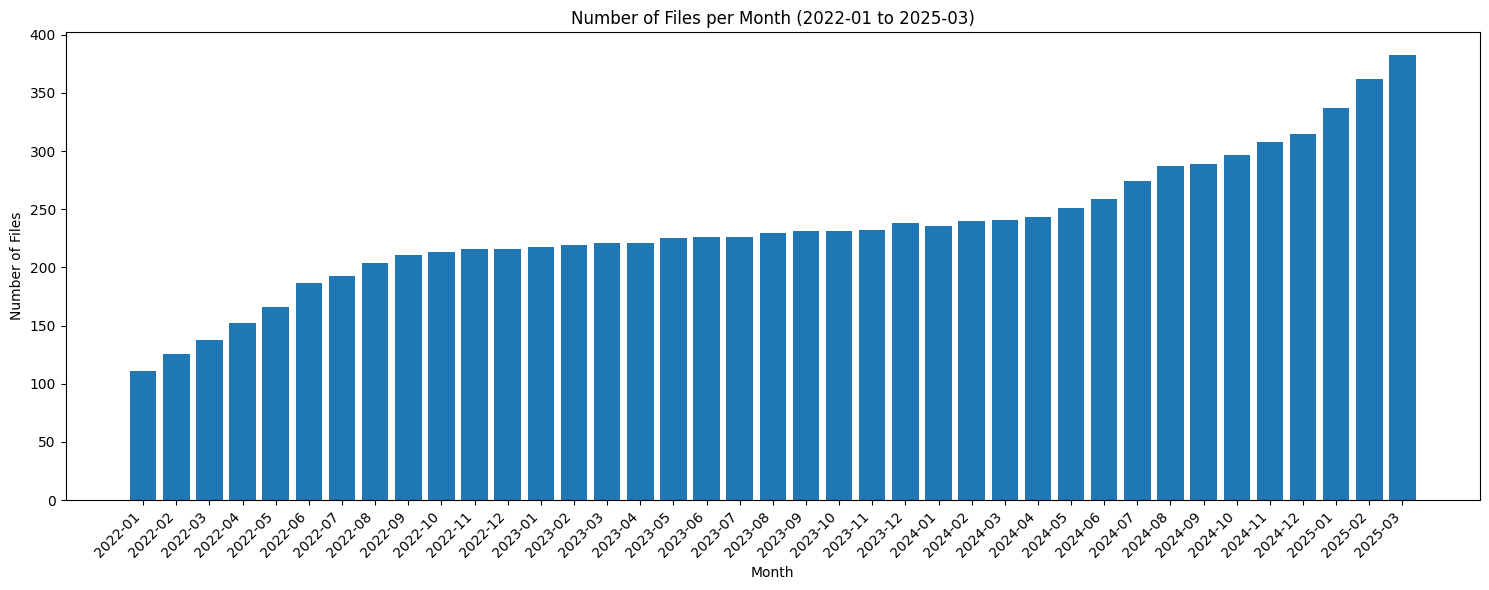

[111, 126, 138, 152, 166, 187, 193, 204, 211, 213, 216, 216, 218, 219, 221, 221, 225, 226, 226, 230, 231, 231, 232, 238, 236, 240, 241, 243, 251, 259, 274, 287, 289, 297, 308, 315, 337, 362, 383]


In [7]:
files = analyze_monthly_coverage('2022-01', '2025-03', 0)
print([len(lst) for lst in files])

### Produce Concatenated Datasets 

Use lists given by `check timestamp coverage` and `analyze monthly coverage`

Code copied from `timestamp_coverage.py` 